# 意思決定分析と予測の活用｜第2部 決定分析の基礎
https://logics-of-blue.com/decision-analysis-and-forecast-book-support/

## 第5章 情報の量

### Pythonによる分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)
# 本文の数値とあわせるために、小数点以下3桁で丸める
pd.set_option('display.precision', 3)

### 自己情報量

#### 関数の作成

In [2]:
def self_info(prob):
    return(-1 * np.log2(prob))

#### 自己情報量の計算例

In [3]:
i_6 = self_info(1/6)
print(f'6の目が出たとわかったときの自己情報量：{i_6:.3g}')

6の目が出たとわかったときの自己情報量：2.58


In [4]:
i_3mul = self_info(1/3)
i_even = self_info(1/2) 
print(f'3の倍数とわかったときの自己情報量　 ：{i_3mul:.3g}')
print(f'偶数であるとわかったときの自己情報量：{i_even:.3g}')
print(f'情報を小出しにされたときの合計値    ：{i_3mul + i_even:.3g}')

3の倍数とわかったときの自己情報量　 ：1.58
偶数であるとわかったときの自己情報量：1
情報を小出しにされたときの合計値    ：2.58


### 平均情報量と情報エントロピー

#### 計算方法の確認

In [5]:
# 好況と不況の確率
prob_state = pd.Series([0.4, 0.6])
prob_state.index = ['好況', '不況']
prob_state

好況    0.4
不況    0.6
dtype: float64

In [6]:
# エントロピー計算
H = prob_state[0] * self_info(prob_state[0]) + \
    prob_state[1] * self_info(prob_state[1])
print(f'{H:.3g}')

0.971


#### 効率的な実装

In [7]:
from scipy.stats import entropy

In [8]:
H_stats = entropy(prob_state, base=2)
print(f'{H_stats:.3g}')

0.971


In [9]:
# 確率の合計が1になっていない場合は、勝手に標準化される
H_normalize = entropy(pd.Series([0.2, 0.3]), base=2)
print(f'{H_normalize:.3g}')

0.971


In [10]:
# 参考
# もちろん、定義通り計算したら、異なる結果になる
prob_state_2 = pd.Series([0.2, 0.3])
H_2 = prob_state_2[0] * self_info(prob_state_2[0]) + \
      prob_state_2[1] * self_info(prob_state_2[1])
print(f'{H_2:.3g}')

0.985


### 情報エントロピーの性質

In [11]:
# 11種類の確率分布を作る
prob_df = pd.DataFrame({
    'p1': np.arange(start=0, stop=1.1, step=0.1),
    'p2': 1 - np.arange(start=0, stop=1.1, step=0.1)
})
print(prob_df.head(3))

    p1   p2
0  0.0  1.0
1  0.1  0.9
2  0.2  0.8


In [12]:
# エントロピーの列を作る
prob_df['entropy'] = prob_df[['p1', 'p2']].apply(entropy, axis=1, base=2)
print(prob_df.head(3))

    p1   p2  entropy
0  0.0  1.0    0.000
1  0.1  0.9    0.469
2  0.2  0.8    0.722


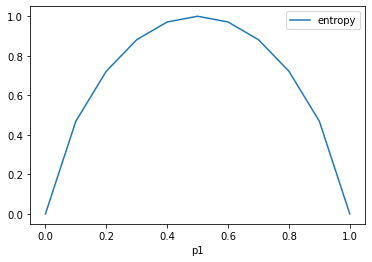

In [13]:
prob_df.plot(x='p1', y='entropy')

### Pythonによる相互情報量の計算

##### 同時分布・周辺分布・条件付き分布

In [14]:
joint_forecast_state = pd.DataFrame({
    '好況予測': [0.35, 0.1],
    '不況予測': [0.05, 0.5]
})
joint_forecast_state.index = ['好況', '不況']
print(joint_forecast_state)

      好況予測  不況予測
好況      0.35      0.05
不況      0.10      0.50


In [15]:
marginal_forecast = joint_forecast_state.sum(axis=0)
marginal_forecast

好況予測    0.45
不況予測    0.55
dtype: float64

In [16]:
marginal_state = joint_forecast_state.sum(axis=1)
marginal_state

好況    0.4
不況    0.6
dtype: float64

In [17]:
# 予測が得られた後の条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis=1)
print(conditional_forecast)

      好況予測  不況予測
好況     0.778     0.091
不況     0.222     0.909


#### 条件付きエントロピー

In [18]:
# 予測結果ごとの不確実性
H_by_f = conditional_forecast.apply(entropy, axis=0, base=2)
H_by_f

好況予測    0.764
不況予測    0.439
dtype: float64

In [19]:
# 予測が得られた後の条件付きエントロピー
H_conditional = H_by_f.mul(marginal_forecast).sum()
print(f'{H_conditional:.3g}')

0.586


#### 相互情報量

In [20]:
# 景気に対する、もともとの不確実性
H_state = entropy(marginal_state, base=2)
print(f'{H_state:.3g}')

0.971


In [21]:
# 予測によって減少した不確実性
# 予測が持っている情報量
# 相互情報量
MI = H_state - H_conditional
print(f'{MI:.3g}')

0.385


### 相互情報量の計算例

In [22]:
def calc_mi(joint_prob_df):
    marginal_forecast = joint_prob_df.sum(axis=0)
    marginal_state = joint_prob_df.sum(axis=1)
    conditional_forecast = joint_prob_df.div(marginal_forecast, axis=1)
    H_by_f = conditional_forecast.apply(entropy, axis=0, base=2)
    H_conditional = H_by_f.mul(marginal_forecast).sum()
    H_state = entropy(marginal_state, base=2)
    MI = H_state - H_conditional
    return(MI)

In [23]:
print(f'需要予測の相互情報量：{calc_mi(joint_forecast_state):.3g}')

需要予測の相互情報量：0.385


#### コインを投げて表なら好況、裏なら不況と主張する情報

In [24]:
coin_result = pd.DataFrame({
    '好況予測': [0.2, 0.3],
    '不況予測': [0.2, 0.3]
})
coin_result.index = ['好況', '不況']
print(coin_result)

      好況予測  不況予測
好況       0.2       0.2
不況       0.3       0.3


In [25]:
print(f'コイン投げの相互情報量：{calc_mi(coin_result):.3g}')

コイン投げの相互情報量：0


#### 完全情報

In [26]:
perfect_forecast = pd.DataFrame({
    '好況予測': [0.4, 0],
    '不況予測': [0, 0.6]
})
perfect_forecast.index = ['好況', '不況']
print(perfect_forecast)

      好況予測  不況予測
好況       0.4       0.0
不況       0.0       0.6


In [27]:
print(f'完全情報の相互情報量：{calc_mi(perfect_forecast):.3g}')

完全情報の相互情報量：0.971


In [28]:
# 景気に対する、もともとの不確実性
marginal_state = perfect_forecast.sum(axis=1)
H_state = entropy(marginal_state, base=2)
print(f'自然の状態が持つ不確実性：{H_state:.3g}')

自然の状態が持つ不確実性：0.971


#### 予測値と実測値が完全に逆になる場合

In [29]:
perversity_forecast = pd.DataFrame({
    '好況予測': [0, 0.6],
    '不況予測': [0.4, 0]
})
perversity_forecast.index = ['好況', '不況']
print(perversity_forecast)

      好況予測  不況予測
好況       0.0       0.4
不況       0.6       0.0


In [30]:
print(f'常に逆を提示する情報の相互情報量：{calc_mi(perversity_forecast):.3g}')

常に逆を提示する情報の相互情報量：0.971


### Pythonによる相対エントロピーの計算

In [31]:
# 予測値別に、条件付き分布を取得
conditional_boom = conditional_forecast['好況予測']
conditional_slump = conditional_forecast['不況予測']

In [32]:
# 相対エントロピーの計算
conditional_boom[0] * np.log2(conditional_boom[0] / marginal_state[0]) + \
    conditional_boom[1] * np.log2(conditional_boom[1] / marginal_state[1])

0.4277319215518185

#### entropy関数を使う

In [33]:
KL_boom = entropy(conditional_boom, base=2, qk=marginal_state)
print(f'好況予測の相対エントロピー：{KL_boom:.3g}')

好況予測の相対エントロピー：0.428


In [34]:
KL_slump = entropy(conditional_slump, base=2, qk=marginal_state)
print(f'不況予測の相対エントロピー：{KL_slump:.3g}')

不況予測の相対エントロピー：0.351


#### apply関数を使って一気に実行

In [35]:
KL = conditional_forecast.apply(entropy, axis=0, base=2, qk=marginal_state)
KL

好況予測    0.428
不況予測    0.351
dtype: float64

### 相対エントロピーの性質

In [36]:
KL_boom_2 = entropy(marginal_state, base=2, qk=conditional_boom)
print(f'好況予測の相対エントロピー　　　　：{KL_boom:.3g}')
print(f'好況予測の相対エントロピー(順序逆)：{KL_boom_2:.3g}')

好況予測の相対エントロピー　　　　：0.428
好況予測の相対エントロピー(順序逆)：0.476


### 相対エントロピーと相互情報量の関係

In [37]:
# 相対エントロピーの期待値
mean_KL = KL.mul(marginal_forecast).sum()

In [38]:
# 相対エントロピーの期待値は、相互情報量と等しい
print(f'相対エントロピーの期待値：{mean_KL:.3g}')
print(f'需要予測の相互情報量　　：{calc_mi(joint_forecast_state):.3g}')

相対エントロピーの期待値：0.385
需要予測の相互情報量　　：0.385
